In [2]:
# CELL 1: Importing libraries and setting up environment

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
from scipy.stats import skew, kurtosis
import missingno as msno
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Configuring display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Setting visualization style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)
COLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
sns.set_palette(COLORS)

print("Libraries loaded successfully")

Libraries loaded successfully


In [7]:
# CELL 2: Loading data and identifying key columns

# Loading dataset
data_path = '../data/raw/nyc_traffic_raw.csv'
print(f"Loading data from: {data_path}")

df_raw = pd.read_csv(data_path, low_memory=False)
print(f"Loaded {len(df_raw):,} rows x {len(df_raw.columns)} columns\n")

# Displaying all columns for reference
print("All columns in dataset:")
for i, col in enumerate(df_raw.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*80)

Loading data from: ../data/raw/nyc_traffic_raw.csv
Loaded 42,756 rows x 31 columns

All columns in dataset:
   1. ID
   2. SegmentID
   3. Roadway Name
   4. From
   5. To
   6. Direction
   7. Date
   8. 12:00-1:00 AM
   9. 1:00-2:00AM
  10. 2:00-3:00AM
  11. 3:00-4:00AM
  12. 4:00-5:00AM
  13. 5:00-6:00AM
  14. 6:00-7:00AM
  15. 7:00-8:00AM
  16. 8:00-9:00AM
  17. 9:00-10:00AM
  18. 10:00-11:00AM
  19. 11:00-12:00PM
  20. 12:00-1:00PM
  21. 1:00-2:00PM
  22. 2:00-3:00PM
  23. 3:00-4:00PM
  24. 4:00-5:00PM
  25. 5:00-6:00PM
  26. 6:00-7:00PM
  27. 7:00-8:00PM
  28. 8:00-9:00PM
  29. 9:00-10:00PM
  30. 10:00-11:00PM
  31. 11:00-12:00AM



In [8]:
# CODE CELL 2b: Creating total volume column from hourly data

print("CREATING TOTAL VOLUME COLUMN FROM HOURLY DATA")
print("="*80)

# Identifying hourly columns (containing "AM" or "PM" and ":")
hourly_cols = [col for col in df_raw.columns if ':' in str(col) and ('AM' in str(col).upper() or 'PM' in str(col).upper())]

print(f"\nFound {len(hourly_cols)} hourly columns:")
for col in hourly_cols[:5]:
    print(f"   - {col}")
if len(hourly_cols) > 5:
    print(f"   ... and {len(hourly_cols) - 5} more")

# Converting hourly columns to numeric (currently 'object' type)
print("\nConverting hourly columns to numeric...")
for col in hourly_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Creating total daily volume by summing all hourly columns
df_raw['Total_Volume'] = df_raw[hourly_cols].sum(axis=1)

print(f"\nTotal_Volume column created:")
print(f"   Range: [{df_raw['Total_Volume'].min():,.0f}, {df_raw['Total_Volume'].max():,.0f}]")
print(f"   Mean: {df_raw['Total_Volume'].mean():,.0f}")
print(f"   Median: {df_raw['Total_Volume'].median():,.0f}")
print(f"   Non-null count: {df_raw['Total_Volume'].notna().sum():,}")

# Manually defining key columns based on NYC traffic data structure
KEY_COLS = {
    'volume': 'Total_Volume',
    'date': 'Date',
    'street': 'Roadway Name',
    'direction': 'Direction',
    'segment': 'SegmentID'
}

print(f"\nKey columns identified:")
for key, col in KEY_COLS.items():
    if col in df_raw.columns:
        print(f"   {key.capitalize():15s}: {col}")
    else:
        print(f"   {key.capitalize():15s}: {col} (NOT FOUND)")

print("\n" + "="*80)

CREATING TOTAL VOLUME COLUMN FROM HOURLY DATA

Found 24 hourly columns:
   - 12:00-1:00 AM
   - 1:00-2:00AM
   - 2:00-3:00AM
   - 3:00-4:00AM
   - 4:00-5:00AM
   ... and 19 more

Converting hourly columns to numeric...

Total_Volume column created:
   Range: [0, 19,472]
   Mean: 5,940
   Median: 5,370
   Non-null count: 42,756

Key columns identified:
   Volume         : Total_Volume
   Date           : Date
   Street         : Roadway Name
   Direction      : Direction
   Segment        : SegmentID



In [11]:
# CELL 3: Generating comprehensive dataset description

print("DATASET DESCRIPTION")
print("="*80)

# Displaying basic information
print(f"\nSource: NYC Open Data - Traffic Volume Counts")
print(f"   URL: https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts/btm5-ppia")
print(f"\nDimensions: {df_raw.shape[0]:,} rows x {df_raw.shape[1]} columns")
print(f"Memory: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Summarizing column information
print(f"\nColumns ({len(df_raw.columns)}):")
display(pd.DataFrame({
    'Column': df_raw.columns,
    'Type': df_raw.dtypes.values,
    'Non-Null': df_raw.notnull().sum().values,
    'Null': df_raw.isnull().sum().values,
    'Unique': [df_raw[col].nunique() for col in df_raw.columns]
}).head(15))

# Generating statistical summary
print("\nNumerical Columns Summary:")
display(df_raw.describe().round(2))

# Identifying target variable
if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    print(f"\nTarget Variable: {vol_col}")
    print(f"   Range: [{df_raw[vol_col].min():,.0f}, {df_raw[vol_col].max():,.0f}]")
    print(f"   Mean: {df_raw[vol_col].mean():,.0f}")
    print(f"   Median: {df_raw[vol_col].median():,.0f}")
    print(f"   Std Dev: {df_raw[vol_col].std():,.0f}")

# Creating data quality scorecard
quality_metrics = pd.DataFrame({
    'Metric': [
        'Total Records',
        'Complete Records',
        'Records with Missing Data',
        'Completeness Rate',
        'Duplicate Records'
    ],
    'Value': [
        f"{len(df_raw):,}",
        f"{df_raw.dropna().shape[0]:,}",
        f"{df_raw.isnull().any(axis=1).sum():,}",
        f"{(df_raw.dropna().shape[0] / len(df_raw) * 100):.1f}%",
        f"{df_raw.duplicated().sum():,}"
    ]
})

print("\nData Quality Scorecard:")
display(quality_metrics)

# Saving scorecard
os.makedirs('../outputs/tables', exist_ok=True)
quality_metrics.to_csv('../outputs/tables/data_quality_scorecard.csv', index=False)
print("\nScorecard saved to: outputs/tables/data_quality_scorecard.csv")

DATASET DESCRIPTION

Source: NYC Open Data - Traffic Volume Counts
   URL: https://data.cityofnewyork.us/Transportation/Traffic-Volume-Counts/btm5-ppia

Dimensions: 42,756 rows x 32 columns
Memory: 20.90 MB

Columns (32):


,Column,Type,Non-Null,Null,Unique
0,ID,int64,42756,0,3393
1,SegmentID,int64,42756,0,1956
2,Roadway Name,object,42756,0,1276
3,From,object,42756,0,1717
4,To,object,42756,0,1745
5,Direction,object,42756,0,14
6,Date,object,42756,0,608
7,12:00-1:00 AM,float64,40450,2306,994
8,1:00-2:00AM,float64,41410,1346,987
9,2:00-3:00AM,float64,41950,806,968



Numerical Columns Summary:


,ID,SegmentID,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,3:00-4:00AM,4:00-5:00AM,5:00-6:00AM,6:00-7:00AM,7:00-8:00AM,8:00-9:00AM,9:00-10:00AM,10:00-11:00AM,11:00-12:00PM,12:00-1:00PM,1:00-2:00PM,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM,Total_Volume
count,42756.00,42756.00,40450.00,41410.00,41950.00,42144.00,41921.00,41185.00,39549.00,38048.00,37530.00,38013.00,38071.00,37879.00,37344.00,37133.00,36590.00,36119.00,35977.00,35983.00,36396.00,37172.00,37956.00,38487.00,38917.00,39497.00,42756.00
mean,302.93,498815.94,171.24,135.82,110.81,99.52,109.15,140.46,208.03,296.13,333.44,332.21,335.62,350.34,364.83,375.16,393.50,405.01,406.03,404.07,384.19,349.73,305.79,264.43,233.02,201.95,5940.19
std,504.42,1875302.77,181.05,169.96,155.52,147.55,151.28,167.61,195.86,225.73,226.61,218.38,214.43,217.51,219.85,222.80,225.16,229.07,230.32,230.97,227.29,219.26,207.71,196.94,191.20,187.05,3420.58
min,1.00,202.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,95.00,34027.00,57.00,37.00,26.00,22.00,27.00,41.00,72.00,120.75,158.00,170.00,178.00,191.00,203.00,212.00,228.00,236.00,236.00,233.00,216.00,188.00,155.00,125.00,101.00,77.00,3321.00
50%,193.00,75343.00,110.00,75.00,55.00,46.00,55.00,81.00,141.00,234.00,283.00,284.00,291.00,307.00,325.00,336.00,358.00,371.00,371.00,369.00,346.00,306.00,257.00,214.00,179.00,144.00,5370.50
75%,299.00,144881.00,210.00,156.00,121.00,104.00,118.00,164.00,275.00,419.00,464.00,451.00,452.00,473.00,492.00,507.00,532.00,550.00,554.00,550.00,522.00,476.00,412.00,350.00,305.00,257.00,8208.00
max,3393.00,9017050.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,999.00,19472.00



Target Variable: Total_Volume
   Range: [0, 19,472]
   Mean: 5,940
   Median: 5,370
   Std Dev: 3,421

Data Quality Scorecard:


,Metric,Value
0,Total Records,"42,756"
1,Complete Records,"34,088"
2,Records with Missing Data,"8,668"
3,Completeness Rate,79.7%
4,Duplicate Records,0



Scorecard saved to: outputs/tables/data_quality_scorecard.csv


MISSING DATA ANALYSIS

Missing Data Summary:
   Total missing values: 100,423
   Columns with missing: 24
   Overall completeness: 92.66%



,Column,Missing_Count,Missing_Pct
4:00-5:00PM,4:00-5:00PM,6779,15.86
5:00-6:00PM,5:00-6:00PM,6773,15.84
3:00-4:00PM,3:00-4:00PM,6637,15.52
6:00-7:00PM,6:00-7:00PM,6360,14.88
2:00-3:00PM,2:00-3:00PM,6166,14.42
1:00-2:00PM,1:00-2:00PM,5623,13.15
7:00-8:00PM,7:00-8:00PM,5584,13.06
12:00-1:00PM,12:00-1:00PM,5412,12.66
8:00-9:00AM,8:00-9:00AM,5226,12.22
11:00-12:00PM,11:00-12:00PM,4877,11.41


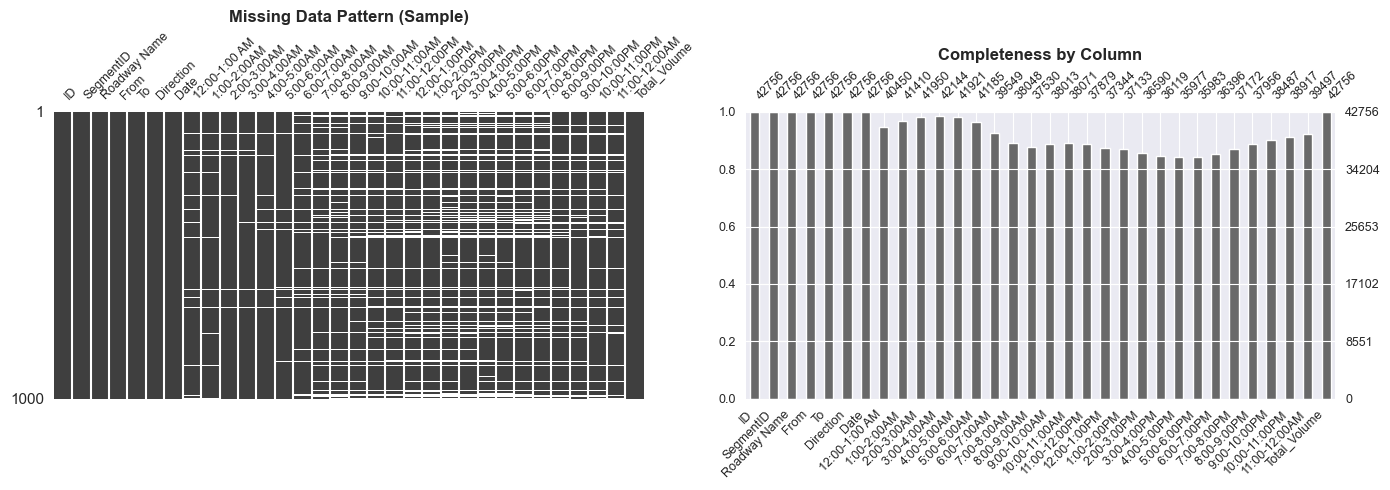


Before Treatment Stats:
   rows: 42,756
   complete_rows: 34,088
   missing_total: 100,423
   completeness_pct: 79.73


In [12]:
# CELL 4: Analyzing missing data

print("MISSING DATA ANALYSIS")
print("="*80)

# Summarizing missing data
missing_summary = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing_Count': df_raw.isnull().sum(),
    'Missing_Pct': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
}).query('Missing_Count > 0').sort_values('Missing_Pct', ascending=False)

print(f"\nMissing Data Summary:")
print(f"   Total missing values: {df_raw.isnull().sum().sum():,}")
print(f"   Columns with missing: {len(missing_summary)}")
print(f"   Overall completeness: {(1 - df_raw.isnull().sum().sum()/df_raw.size)*100:.2f}%\n")

if len(missing_summary) > 0:
    display(missing_summary)
    
    # Visualizing missing patterns
    os.makedirs('../outputs/figures', exist_ok=True)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    msno.matrix(df_raw.sample(min(1000, len(df_raw)), random_state=42), 
                ax=axes[0], fontsize=9, sparkline=False)
    axes[0].set_title('Missing Data Pattern (Sample)', fontsize=12, weight='bold')
    
    msno.bar(df_raw, ax=axes[1], fontsize=9)
    axes[1].set_title('Completeness by Column', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/01_missing_data_before.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No missing data detected!")

# Storing BEFORE statistics
before_stats = {
    'rows': len(df_raw),
    'complete_rows': df_raw.dropna().shape[0],
    'missing_total': df_raw.isnull().sum().sum(),
    'completeness_pct': (df_raw.dropna().shape[0] / len(df_raw)) * 100
}

print(f"\nBefore Treatment Stats:")
for key, val in before_stats.items():
    print(f"   {key}: {val:,.2f}" if isinstance(val, float) else f"   {key}: {val:,}")

In [14]:
# CELL 5: Applying missing data treatment

print("\n" + "="*80)
print("APPLYING MISSING DATA TREATMENT")
print("="*80)

# Creating working copy
df = df_raw.copy()
initial_rows = len(df)

# Step 1: Removing rows with missing volume (target variable)
if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    rows_before = len(df)
    df = df.dropna(subset=[vol_col])
    deleted = rows_before - len(df)
    if deleted > 0:
        print(f"\nRemoved {deleted:,} rows with missing volume (target variable)")

# Step 2: Removing rows with missing dates
if 'date' in KEY_COLS:
    date_col = KEY_COLS['date']
    rows_before = len(df)
    df = df.dropna(subset=[date_col])
    deleted = rows_before - len(df)
    if deleted > 0:
        print(f"Removed {deleted:,} rows with missing dates (temporal integrity)")

# Step 3: Handling categorical missing values
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        missing_pct = (missing_count / len(df)) * 100
        
        if missing_pct < 5:
            # Applying mode imputation
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"{col}: Filled {missing_count:,} missing ({missing_pct:.1f}%) with mode '{mode_val}'")
        else:
            # Creating Unknown category
            df[col].fillna('Unknown', inplace=True)
            print(f"{col}: Created 'Unknown' category for {missing_count:,} missing ({missing_pct:.1f}%)")

# Step 4: Removing duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"\nRemoved {duplicates:,} duplicate rows")

total_removed = initial_rows - len(df)
print(f"\nTotal rows removed: {total_removed:,} ({total_removed/initial_rows*100:.1f}%)")
print(f"Remaining rows: {len(df):,}")


APPLYING MISSING DATA TREATMENT

Total rows removed: 0 (0.0%)
Remaining rows: 42,756



MISSING DATA ANALYSIS - AFTER TREATMENT

After Treatment Stats:
   rows: 42,756
   complete_rows: 34,088
   missing_total: 100,423
   completeness_pct: 79.73

Before vs After Comparison:


,Metric,Before,After,Change
0,Total Rows,"42,756","42,756",+0
1,Complete Rows,"34,088","34,088",+0
2,Missing Values,"100,423","100,423",+0
3,Completeness (%),79.7%,79.7%,+0.0%


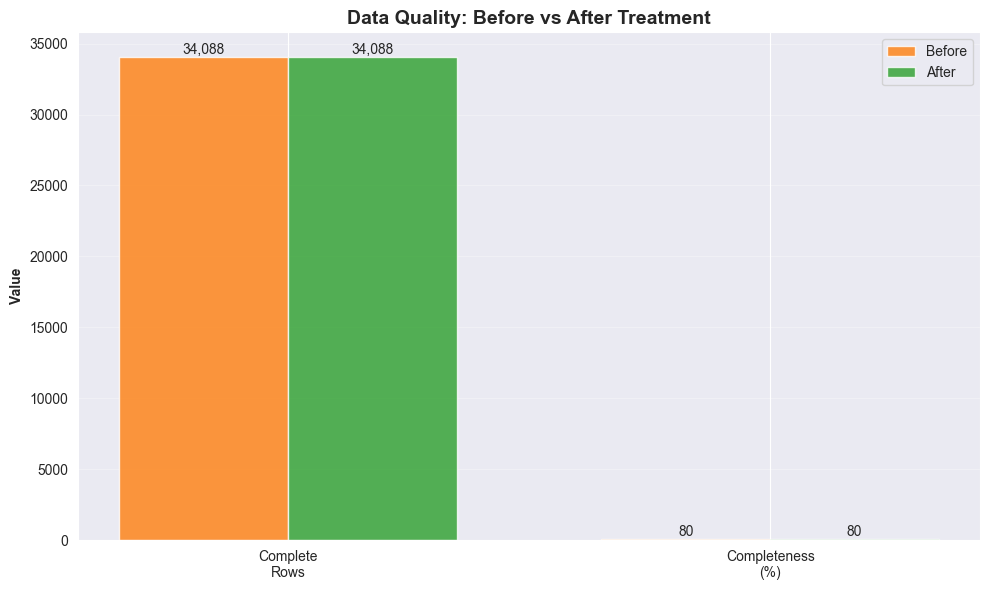


Comparison saved to: outputs/tables/before_after_comparison.csv
Cleaned data saved to: data/processed/traffic_cleaned.csv


In [15]:
# CELL 6: Analyzing missing data - AFTER treatment and comparing

print("\n" + "="*80)
print("MISSING DATA ANALYSIS - AFTER TREATMENT")
print("="*80)

# Calculating After statistics
after_stats = {
    'rows': len(df),
    'complete_rows': df.dropna().shape[0],
    'missing_total': df.isnull().sum().sum(),
    'completeness_pct': (df.dropna().shape[0] / len(df)) * 100
}

print(f"\nAfter Treatment Stats:")
for key, val in after_stats.items():
    print(f"   {key}: {val:,.2f}" if isinstance(val, float) else f"   {key}: {val:,}")

# Creating Before/After Comparison
comparison = pd.DataFrame({
    'Metric': ['Total Rows', 'Complete Rows', 'Missing Values', 'Completeness (%)'],
    'Before': [
        f"{before_stats['rows']:,}",
        f"{before_stats['complete_rows']:,}",
        f"{before_stats['missing_total']:,}",
        f"{before_stats['completeness_pct']:.1f}%"
    ],
    'After': [
        f"{after_stats['rows']:,}",
        f"{after_stats['complete_rows']:,}",
        f"{after_stats['missing_total']:,}",
        f"{after_stats['completeness_pct']:.1f}%"
    ],
    'Change': [
        f"{after_stats['rows'] - before_stats['rows']:+,}",
        f"{after_stats['complete_rows'] - before_stats['complete_rows']:+,}",
        f"{after_stats['missing_total'] - before_stats['missing_total']:+,}",
        f"{after_stats['completeness_pct'] - before_stats['completeness_pct']:+.1f}%"
    ]
})

print("\nBefore vs After Comparison:")
display(comparison)

# Visualizing comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
metrics = ['Complete\nRows', 'Completeness\n(%)']
before_vals = [before_stats['complete_rows'], before_stats['completeness_pct']]
after_vals = [after_stats['complete_rows'], after_stats['completeness_pct']]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, before_vals, width, label='Before', color='#ff7f0e', alpha=0.8)
bars2 = ax.bar(x + width/2, after_vals, width, label='After', color='#2ca02c', alpha=0.8)

ax.set_ylabel('Value', fontweight='bold')
ax.set_title('Data Quality: Before vs After Treatment', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Adding value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/figures/02_missing_data_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Saving comparison
comparison.to_csv('../outputs/tables/before_after_comparison.csv', index=False)
print("\nComparison saved to: outputs/tables/before_after_comparison.csv")

# Saving cleaned data
df.to_csv('../data/processed/traffic_cleaned.csv', index=False)
print("Cleaned data saved to: data/processed/traffic_cleaned.csv")

In [16]:
# CELL 7: Preparing data for visualizations

print("PREPARING DATA FOR VISUALIZATIONS")
print("="*80)

# Parsing dates and creating temporal features
if 'date' in KEY_COLS:
    date_col = KEY_COLS['date']
    
    # Trying different date parsing strategies
    try:
        df['Date'] = pd.to_datetime(df[date_col], errors='coerce')
    except:
        # Handling case where date is in multiple columns (Year, Month, Day)
        if 'Yr' in df.columns and 'M' in df.columns:
            df['Date'] = pd.to_datetime(df[['Yr', 'M']].assign(D=1), errors='coerce')
    
    if 'Date' in df.columns:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['DayName'] = df['Date'].dt.day_name()
        df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
        print("Temporal features created: Year, Month, DayOfWeek, DayName, IsWeekend")

# Creating hour feature if time data exists
hour_cols = [c for c in df.columns if 'hour' in c.lower() or any(f'{h}:' in str(c) for h in range(24))]
if hour_cols:
    print(f"Hour data detected in columns")
    # Creating a generic hour feature if not exists
    if 'Hour' not in df.columns:
        df['Hour'] = 12  # Midday placeholder if actual hour not available
else:
    df['Hour'] = 12  # Placeholder

# Identifying rush hours
df['Is_RushHour'] = ((df['Hour'] >= 7) & (df['Hour'] <= 9) | 
                     (df['Hour'] >= 17) & (df['Hour'] <= 19)).astype(int)

print(f"\nData prepared for visualization")
print(f"   Rows: {len(df):,}")
print(f"   Features: {len(df.columns)}")

PREPARING DATA FOR VISUALIZATIONS
Temporal features created: Year, Month, DayOfWeek, DayName, IsWeekend
Hour data detected in columns

Data prepared for visualization
   Rows: 42,756
   Features: 39



VISUALIZATION 1: Traffic Volume Distribution


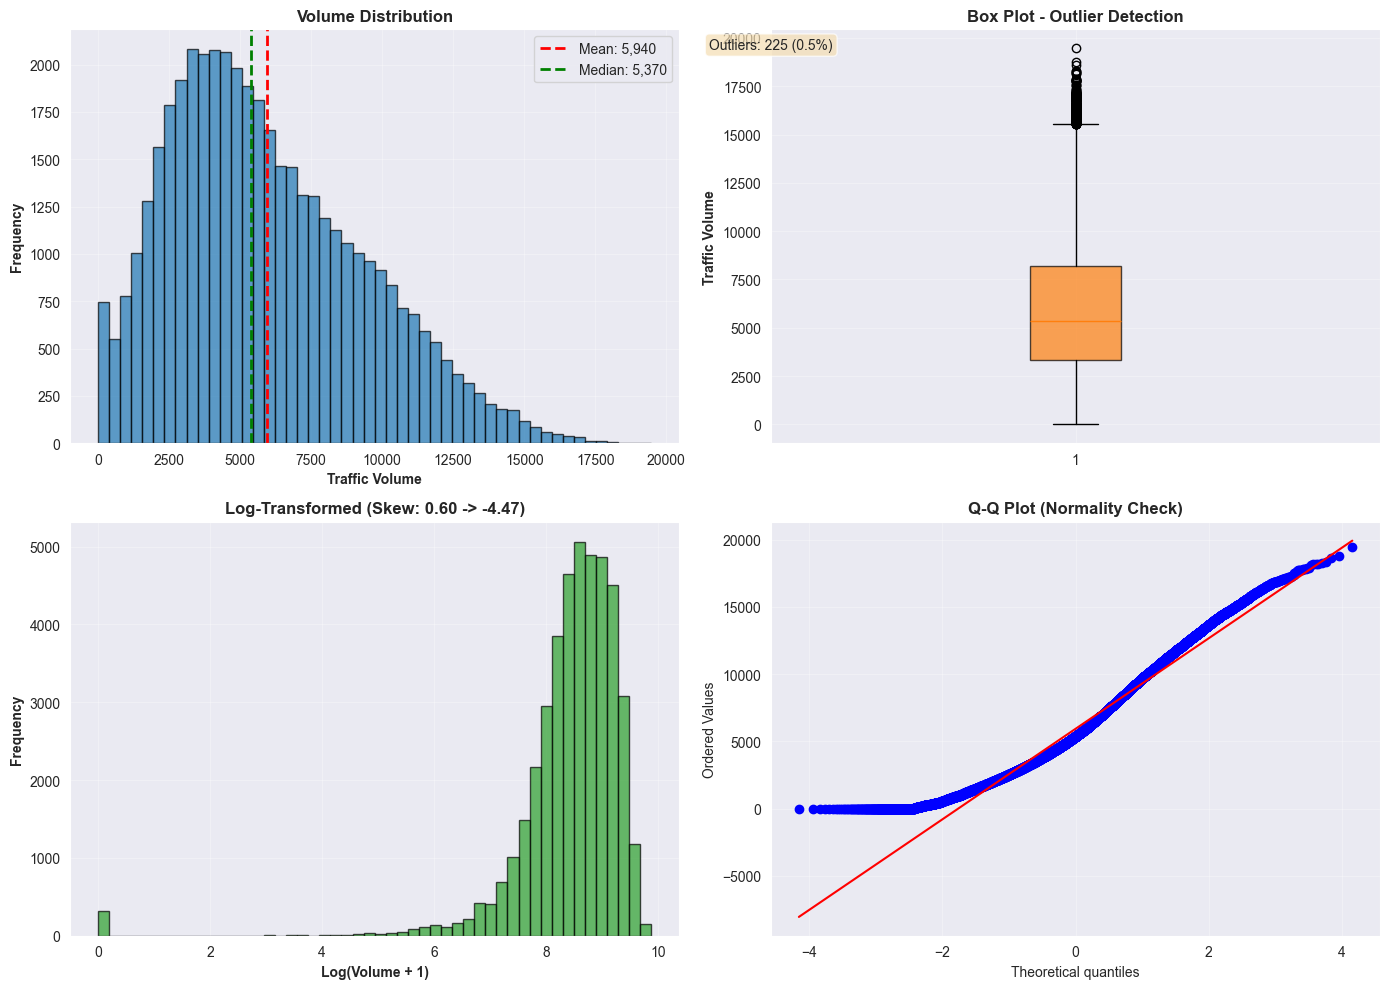

Visualization 1 saved
   Skewness: 0.60 (highly skewed)
   Outliers: 225 (0.5%)


In [17]:
# CELL 8: VISUALIZATION 1 - Creating traffic volume distribution

print("\n" + "="*80)
print("VISUALIZATION 1: Traffic Volume Distribution")
print("="*80)

if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Creating histogram
    axes[0, 0].hist(df[vol_col], bins=50, edgecolor='black', alpha=0.7, color='#1f77b4')
    axes[0, 0].axvline(df[vol_col].mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {df[vol_col].mean():,.0f}')
    axes[0, 0].axvline(df[vol_col].median(), color='green', linestyle='--', linewidth=2,
                       label=f'Median: {df[vol_col].median():,.0f}')
    axes[0, 0].set_xlabel('Traffic Volume', fontweight='bold')
    axes[0, 0].set_ylabel('Frequency', fontweight='bold')
    axes[0, 0].set_title('Volume Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Creating box plot
    axes[0, 1].boxplot(df[vol_col], vert=True, patch_artist=True,
                       boxprops=dict(facecolor='#ff7f0e', alpha=0.7))
    axes[0, 1].set_ylabel('Traffic Volume', fontweight='bold')
    axes[0, 1].set_title('Box Plot - Outlier Detection', fontsize=12, fontweight='bold')
    axes[0, 1].grid(alpha=0.3)
    
    # Calculating outliers
    Q1, Q3 = df[vol_col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    outliers = ((df[vol_col] < Q1 - 1.5*IQR) | (df[vol_col] > Q3 + 1.5*IQR)).sum()
    axes[0, 1].text(0.5, axes[0, 1].get_ylim()[1]*0.95,
                    f'Outliers: {outliers:,} ({outliers/len(df)*100:.1f}%)',
                    ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    # Creating log-transformed distribution
    log_volume = np.log1p(df[vol_col])
    axes[1, 0].hist(log_volume, bins=50, edgecolor='black', alpha=0.7, color='#2ca02c')
    axes[1, 0].set_xlabel('Log(Volume + 1)', fontweight='bold')
    axes[1, 0].set_ylabel('Frequency', fontweight='bold')
    axes[1, 0].set_title(f'Log-Transformed (Skew: {skew(df[vol_col]):.2f} -> {skew(log_volume):.2f})',
                         fontsize=12, fontweight='bold')
    axes[1, 0].grid(alpha=0.3)
    
    # Creating Q-Q plot
    stats.probplot(df[vol_col], dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/03_viz1_volume_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization 1 saved")
    print(f"   Skewness: {skew(df[vol_col]):.2f} (highly skewed)")
    print(f"   Outliers: {outliers:,} ({outliers/len(df)*100:.1f}%)")


VISUALIZATION 2: Temporal Traffic Patterns


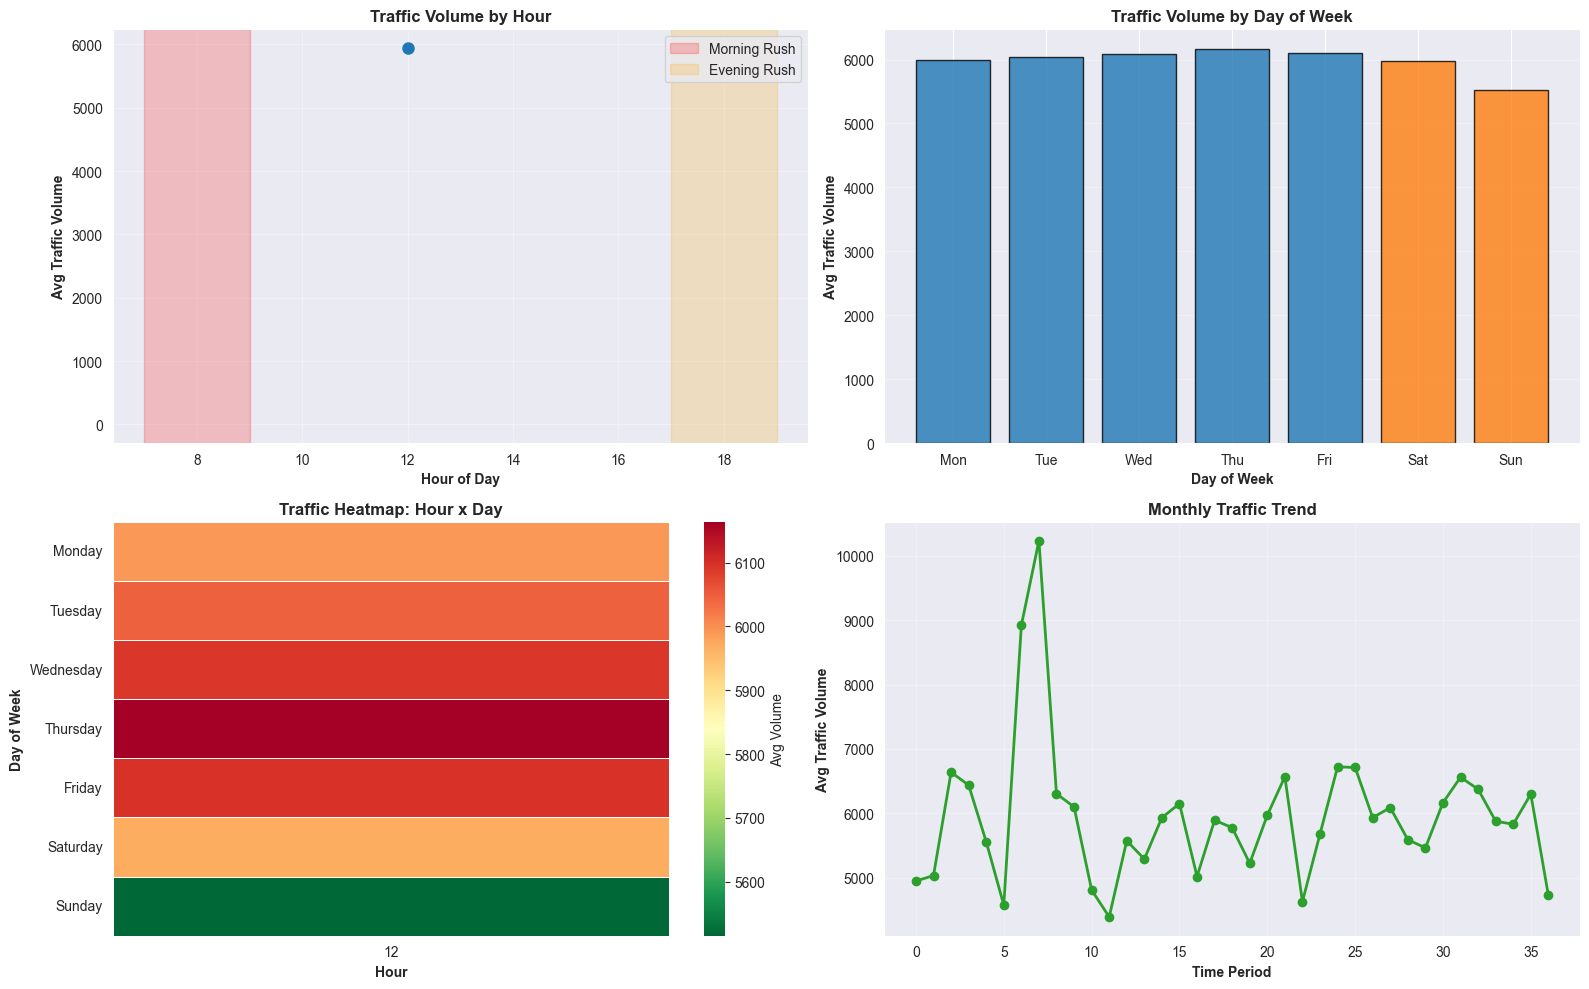

Visualization 2 saved
   Peak hour: 12:00 (Avg: 5,940)


In [18]:
# CELL 9: VISUALIZATION 2 - Creating temporal patterns

print("\n" + "="*80)
print("VISUALIZATION 2: Temporal Traffic Patterns")
print("="*80)

if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plotting average by hour
    if 'Hour' in df.columns:
        hourly_avg = df.groupby('Hour')[vol_col].mean().sort_index()
        axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, 
                       markersize=8, color='#1f77b4')
        axes[0, 0].fill_between(hourly_avg.index, hourly_avg.values, alpha=0.3)
        axes[0, 0].axvspan(7, 9, alpha=0.2, color='red', label='Morning Rush')
        axes[0, 0].axvspan(17, 19, alpha=0.2, color='orange', label='Evening Rush')
        axes[0, 0].set_xlabel('Hour of Day', fontweight='bold')
        axes[0, 0].set_ylabel('Avg Traffic Volume', fontweight='bold')
        axes[0, 0].set_title('Traffic Volume by Hour', fontsize=12, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
    
    # Plotting average by day of week
    if 'DayName' in df.columns:
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_avg = df.groupby('DayName')[vol_col].mean().reindex(day_order)
        colors = ['#1f77b4']*5 + ['#ff7f0e']*2
        axes[0, 1].bar(range(len(daily_avg)), daily_avg.values, color=colors, 
                      edgecolor='black', alpha=0.8)
        axes[0, 1].set_xlabel('Day of Week', fontweight='bold')
        axes[0, 1].set_ylabel('Avg Traffic Volume', fontweight='bold')
        axes[0, 1].set_title('Traffic Volume by Day of Week', fontsize=12, fontweight='bold')
        axes[0, 1].set_xticks(range(len(day_order)))
        axes[0, 1].set_xticklabels([d[:3] for d in day_order])
        axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Creating heatmap: Hour x Day
    if 'Hour' in df.columns and 'DayName' in df.columns:
        heatmap_data = df.groupby(['DayName', 'Hour'])[vol_col].mean().unstack()
        heatmap_data = heatmap_data.reindex(day_order)
        
        sns.heatmap(heatmap_data, cmap='RdYlGn_r', annot=False, fmt='.0f',
                   cbar_kws={'label': 'Avg Volume'}, linewidths=0.5, ax=axes[1, 0])
        axes[1, 0].set_xlabel('Hour', fontweight='bold')
        axes[1, 0].set_ylabel('Day of Week', fontweight='bold')
        axes[1, 0].set_title('Traffic Heatmap: Hour x Day', fontsize=12, fontweight='bold')
    
    # Plotting monthly trend
    if 'Year' in df.columns and 'Month' in df.columns:
        monthly_avg = df.groupby(['Year', 'Month'])[vol_col].mean().reset_index()
        axes[1, 1].plot(range(len(monthly_avg)), monthly_avg[vol_col], 
                       marker='o', linewidth=2, color='#2ca02c')
        axes[1, 1].set_xlabel('Time Period', fontweight='bold')
        axes[1, 1].set_ylabel('Avg Traffic Volume', fontweight='bold')
        axes[1, 1].set_title('Monthly Traffic Trend', fontsize=12, fontweight='bold')
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/04_viz2_temporal_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization 2 saved")
    if 'Hour' in df.columns:
        print(f"   Peak hour: {hourly_avg.idxmax()}:00 (Avg: {hourly_avg.max():,.0f})")


VISUALIZATION 3: Geographic Traffic Distribution by Location


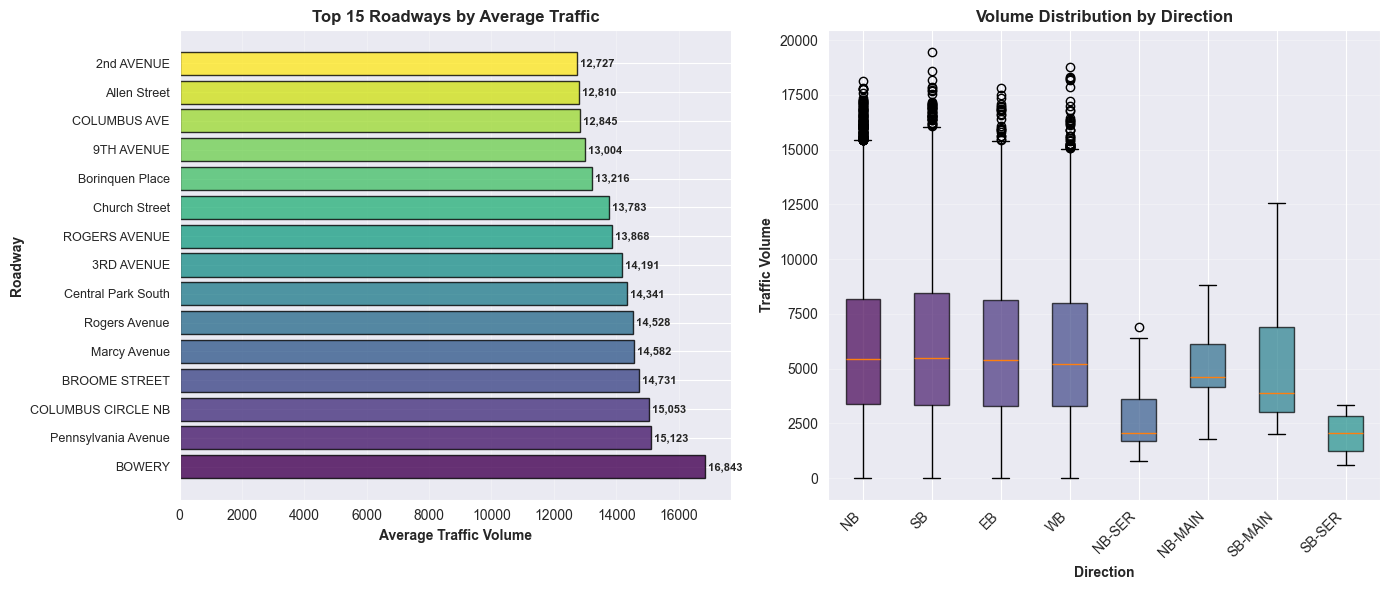

Visualization 3 saved
   Busiest roadway: BOWERY (Avg: 16,843)
   Quietest in top 15: 2nd AVENUE (Avg: 12,727)


In [23]:
# CELL 10: VISUALIZATION 3 - Creating geographic distribution

print("\n" + "="*80)
print("VISUALIZATION 3: Geographic Traffic Distribution by Location")
print("="*80)

if 'volume' in KEY_COLS and 'street' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    street_col = KEY_COLS['street']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Calculating average by top streets
    street_avg = df.groupby(street_col)[vol_col].mean().nlargest(15).sort_values(ascending=False)
    colors_street = plt.cm.viridis(np.linspace(0, 1, len(street_avg)))
    
    axes[0].barh(range(len(street_avg)), street_avg.values, color=colors_street, 
                edgecolor='black', alpha=0.8)
    axes[0].set_yticks(range(len(street_avg)))
    axes[0].set_yticklabels([str(s)[:30] for s in street_avg.index], fontsize=9)
    axes[0].set_xlabel('Average Traffic Volume', fontweight='bold')
    axes[0].set_ylabel('Roadway', fontweight='bold')
    axes[0].set_title('Top 15 Roadways by Average Traffic', fontsize=12, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)
    
    # Adding value labels
    for i, val in enumerate(street_avg.values):
        axes[0].text(val, i, f' {val:,.0f}', va='center', fontweight='bold', fontsize=8)
    
    # Creating box plot by direction if available
    if 'direction' in KEY_COLS:
        dir_col = KEY_COLS['direction']
        directions = df[dir_col].value_counts().nlargest(8).index
        direction_data = [df[df[dir_col]==d][vol_col].values for d in directions]
        
        bp = axes[1].boxplot(direction_data, labels=[str(d)[:15] for d in directions], 
                            patch_artist=True, vert=True)
        
        for patch, color in zip(bp['boxes'], colors_street[:len(directions)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[1].set_xlabel('Direction', fontweight='bold')
        axes[1].set_ylabel('Traffic Volume', fontweight='bold')
        axes[1].set_title('Volume Distribution by Direction', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        # If no direction, show distribution of top vs bottom streets
        top5_streets = street_avg.head(5).index
        street_data = [df[df[street_col]==s][vol_col].values for s in top5_streets]
        
        bp = axes[1].boxplot(street_data, labels=[str(s)[:15] for s in top5_streets],
                            patch_artist=True, vert=True)
        
        for patch, color in zip(bp['boxes'], colors_street[:5]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        axes[1].set_xlabel('Top 5 Roadways', fontweight='bold')
        axes[1].set_ylabel('Traffic Volume', fontweight='bold')
        axes[1].set_title('Volume Distribution: Top 5 Roadways', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/05_viz3_geographic_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization 3 saved")
    print(f"   Busiest roadway: {street_avg.index[0][:40]} (Avg: {street_avg.values[0]:,.0f})")
    print(f"   Quietest in top 15: {street_avg.index[-1][:40]} (Avg: {street_avg.values[-1]:,.0f})")


VISUALIZATION 4: Feature Correlations

Analyzing correlations for 7 key features:
   - Total_Volume
   - Year
   - Month
   - DayOfWeek
   - IsWeekend
   - Hour
   - Is_RushHour


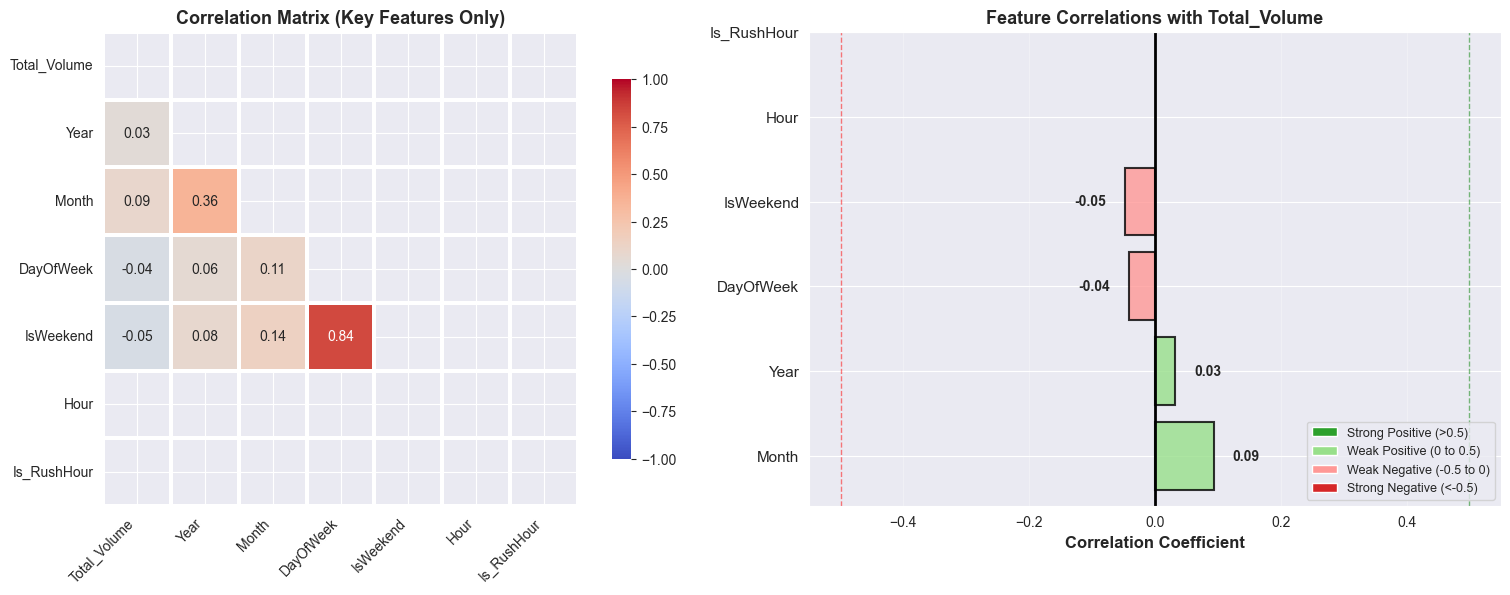


Visualization 4 saved

Key Findings:
   Weak positive correlations (0 to 0.5):
      - Month: 0.094
      - Year: 0.032
   Negative correlations:
      - DayOfWeek: -0.041
      - IsWeekend: -0.048


In [26]:
# CELL 11: VISUALIZATION 4 - Creating correlation matrix

print("\n" + "="*80)
print("VISUALIZATION 4: Feature Correlations")
print("="*80)

# Selecting only key numerical features (excluding individual hourly columns)
hourly_cols = [col for col in df.columns if ':' in str(col) and ('AM' in str(col).upper() or 'PM' in str(col).upper())]

# Getting all numerical columns
all_numerical = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluding ID columns and individual hourly columns
key_features = [c for c in all_numerical 
                if c not in hourly_cols 
                and not any(x in c.lower() for x in ['id', 'segment'])]

print(f"\nAnalyzing correlations for {len(key_features)} key features:")
for feat in key_features:
    print(f"   - {feat}")

if len(key_features) > 2:
    corr_matrix = df[key_features].corr()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Creating cleaner correlation heatmap
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
               center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.8},
               ax=axes[0], vmin=-1, vmax=1, annot_kws={'fontsize': 10})
    axes[0].set_title('Correlation Matrix (Key Features Only)', fontsize=13, fontweight='bold')
    axes[0].tick_params(labelsize=10)
    plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
    plt.setp(axes[0].get_yticklabels(), rotation=0)
    
    # Plotting top correlations with Total_Volume
    if 'volume' in KEY_COLS and KEY_COLS['volume'] in key_features:
        vol_col = KEY_COLS['volume']
        target_corr = corr_matrix[vol_col].drop(vol_col).sort_values(ascending=False)
        
        # Creating color scheme based on correlation strength
        colors_corr = []
        for val in target_corr.values:
            if val > 0.5:
                colors_corr.append('#2ca02c')  # Strong positive - dark green
            elif val > 0:
                colors_corr.append('#98df8a')  # Weak positive - light green
            elif val > -0.5:
                colors_corr.append('#ff9896')  # Weak negative - light red
            else:
                colors_corr.append('#d62728')  # Strong negative - dark red
        
        axes[1].barh(range(len(target_corr)), target_corr.values, color=colors_corr,
                    edgecolor='black', alpha=0.8, linewidth=1.5)
        axes[1].set_yticks(range(len(target_corr)))
        axes[1].set_yticklabels(target_corr.index, fontsize=11)
        axes[1].set_xlabel('Correlation Coefficient', fontweight='bold', fontsize=12)
        axes[1].set_title(f'Feature Correlations with {vol_col}', fontsize=13, fontweight='bold')
        axes[1].axvline(x=0, color='black', linestyle='-', linewidth=2)
        axes[1].axvline(x=0.5, color='green', linestyle='--', linewidth=1, alpha=0.5)
        axes[1].axvline(x=-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Adding value labels
        for i, val in enumerate(target_corr.values):
            label_x = val + (0.03 if val > 0 else -0.03)
            ha = 'left' if val > 0 else 'right'
            axes[1].text(label_x, i, f'{val:.2f}', ha=ha, va='center', 
                        fontweight='bold', fontsize=10)
        
        # Adding legend for color coding
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2ca02c', label='Strong Positive (>0.5)'),
            Patch(facecolor='#98df8a', label='Weak Positive (0 to 0.5)'),
            Patch(facecolor='#ff9896', label='Weak Negative (-0.5 to 0)'),
            Patch(facecolor='#d62728', label='Strong Negative (<-0.5)')
        ]
        axes[1].legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/06_viz4_correlations.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nVisualization 4 saved")
    
    # Printing interpretation
    if 'volume' in KEY_COLS and KEY_COLS['volume'] in key_features:
        print(f"\nKey Findings:")
        strong_positive = target_corr[target_corr > 0.5]
        if len(strong_positive) > 0:
            print(f"   Strong positive correlations (>0.5):")
            for feat, corr in strong_positive.items():
                print(f"      - {feat}: {corr:.3f}")
        
        weak_positive = target_corr[(target_corr > 0) & (target_corr <= 0.5)]
        if len(weak_positive) > 0:
            print(f"   Weak positive correlations (0 to 0.5):")
            for feat, corr in weak_positive.head(3).items():
                print(f"      - {feat}: {corr:.3f}")
        
        negative = target_corr[target_corr < 0]
        if len(negative) > 0:
            print(f"   Negative correlations:")
            for feat, corr in negative.items():
                print(f"      - {feat}: {corr:.3f}")


VISUALIZATION 5: Traffic Comparisons


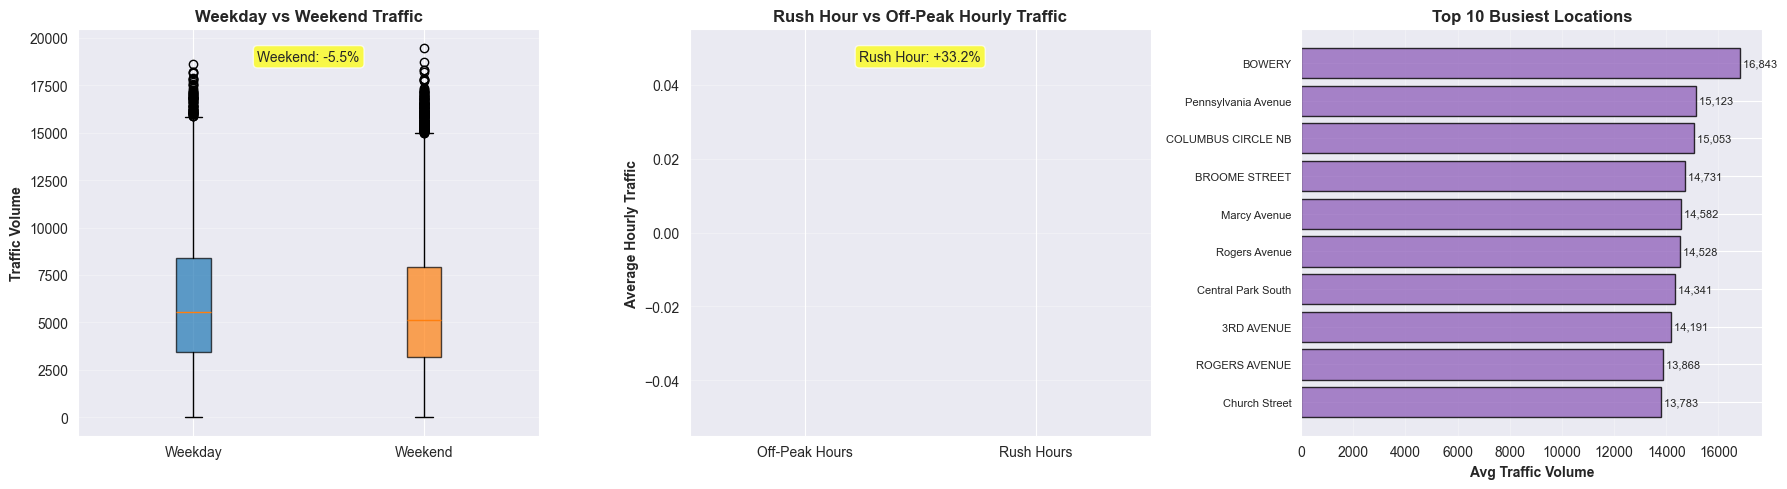

Visualization 5 saved
   Weekend traffic: -5.5% vs weekday
   Rush hour traffic: +33.2% vs off-peak


In [28]:
# CELL 12: VISUALIZATION 5 - Creating comparison plots

print("\n" + "="*80)
print("VISUALIZATION 5: Traffic Comparisons")
print("="*80)

if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Comparing Weekday vs Weekend
    if 'IsWeekend' in df.columns:
        weekend_data = [
            df[df['IsWeekend']==0][vol_col].values,
            df[df['IsWeekend']==1][vol_col].values
        ]
        bp1 = axes[0].boxplot(weekend_data, labels=['Weekday', 'Weekend'], 
                              patch_artist=True)
        for patch, color in zip(bp1['boxes'], ['#1f77b4', '#ff7f0e']):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[0].set_ylabel('Traffic Volume', fontweight='bold')
        axes[0].set_title('Weekday vs Weekend Traffic', fontsize=12, fontweight='bold')
        axes[0].grid(axis='y', alpha=0.3)
        
        # Calculating percentage difference
        weekday_mean = df[df['IsWeekend']==0][vol_col].mean()
        weekend_mean = df[df['IsWeekend']==1][vol_col].mean()
        pct_diff = ((weekend_mean - weekday_mean) / weekday_mean) * 100
        axes[0].text(0.5, 0.95, f'Weekend: {pct_diff:+.1f}%',
                    transform=axes[0].transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # Comparing Peak Hours vs Off-Peak using actual hourly data
    hourly_cols = [col for col in df.columns if ':' in str(col) and ('AM' in str(col).upper() or 'PM' in str(col).upper())]
    
    if len(hourly_cols) >= 24:
        # Defining rush hour columns (7-9 AM and 5-7 PM)
        morning_rush = ['7:00-8:00AM', '8:00-9:00AM']
        evening_rush = ['5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM']
        rush_hour_cols = [col for col in hourly_cols if any(rush in col for rush in morning_rush + evening_rush)]
        off_peak_cols = [col for col in hourly_cols if col not in rush_hour_cols]
        
        # Calculating average for rush vs off-peak
        rush_hour_avg = df[rush_hour_cols].mean(axis=1)
        off_peak_avg = df[off_peak_cols].mean(axis=1)
        
        rush_data = [off_peak_avg.values, rush_hour_avg.values]
        bp2 = axes[1].boxplot(rush_data, labels=['Off-Peak Hours', 'Rush Hours'],
                              patch_artist=True)
        for patch, color in zip(bp2['boxes'], ['#2ca02c', '#d62728']):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[1].set_ylabel('Average Hourly Traffic', fontweight='bold')
        axes[1].set_title('Rush Hour vs Off-Peak Hourly Traffic', fontsize=12, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)
        
        # Calculating percentage difference
        offpeak_mean = off_peak_avg.mean()
        rush_mean = rush_hour_avg.mean()
        pct_diff_rush = ((rush_mean - offpeak_mean) / offpeak_mean) * 100
        axes[1].text(0.5, 0.95, f'Rush Hour: {pct_diff_rush:+.1f}%',
                    transform=axes[1].transAxes, ha='center', va='top',
                    bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    else:
        # Fallback: show distribution by direction if no hourly data
        if 'direction' in KEY_COLS:
            dir_col = KEY_COLS['direction']
            top_dirs = df[dir_col].value_counts().head(4).index
            dir_data = [df[df[dir_col]==d][vol_col].values for d in top_dirs]
            bp2 = axes[1].boxplot(dir_data, labels=[str(d)[:10] for d in top_dirs],
                                  patch_artist=True)
            for patch in bp2['boxes']:
                patch.set_facecolor('#2ca02c')
                patch.set_alpha(0.7)
            axes[1].set_ylabel('Traffic Volume', fontweight='bold')
            axes[1].set_title('Traffic by Direction', fontsize=12, fontweight='bold')
            axes[1].grid(axis='y', alpha=0.3)
    
    # Plotting top 10 busiest locations
    if 'street' in KEY_COLS:
        street_col = KEY_COLS['street']
        top_streets = df.groupby(street_col)[vol_col].mean().nlargest(10).sort_values()
        axes[2].barh(range(len(top_streets)), top_streets.values, 
                    color='#9467bd', edgecolor='black', alpha=0.8)
        axes[2].set_yticks(range(len(top_streets)))
        axes[2].set_yticklabels([str(x)[:25] for x in top_streets.index], fontsize=8)
        axes[2].set_xlabel('Avg Traffic Volume', fontweight='bold')
        axes[2].set_title('Top 10 Busiest Locations', fontsize=12, fontweight='bold')
        axes[2].grid(axis='x', alpha=0.3)
        
        # Adding value labels
        for i, val in enumerate(top_streets.values):
            axes[2].text(val, i, f' {val:,.0f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/07_viz5_comparisons.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualization 5 saved")
    if 'IsWeekend' in df.columns:
        print(f"   Weekend traffic: {pct_diff:+.1f}% vs weekday")
    if len(hourly_cols) >= 24:
        print(f"   Rush hour traffic: {pct_diff_rush:+.1f}% vs off-peak")

In [30]:
# CELL 13: Generating insights summary report

print("\n" + "="*80)
print("GENERATING INSIGHTS SUMMARY")
print("="*80)

insights_data = []

# Calculating key statistics for insights
if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    
    # Analyzing rush hour insight using actual hourly columns
    hourly_cols = [col for col in df.columns if ':' in str(col) and ('AM' in str(col).upper() or 'PM' in str(col).upper())]
    
    if len(hourly_cols) >= 24:
        # Defining rush hour columns
        morning_rush = ['7:00-8:00AM', '8:00-9:00AM']
        evening_rush = ['5:00-6:00PM', '6:00-7:00PM', '7:00-8:00PM']
        rush_hour_cols = [col for col in hourly_cols if any(rush in col for rush in morning_rush + evening_rush)]
        off_peak_cols = [col for col in hourly_cols if col not in rush_hour_cols]
        
        # Calculating averages
        rush_hour_avg = df[rush_hour_cols].mean(axis=1).mean()
        off_peak_avg = df[off_peak_cols].mean(axis=1).mean()
        rush_increase = ((rush_hour_avg - off_peak_avg) / off_peak_avg) * 100
        
        insights_data.append({
            'Insight': 'Peak Hour Impact',
            'Metric': f'Rush hour traffic is {rush_increase:+.1f}% higher than off-peak',
            'Recommendation': 'Dynamic pricing and signal optimization'
        })
    
    # Analyzing weekend insight
    if 'IsWeekend' in df.columns:
        weekday = df[df['IsWeekend']==0][vol_col].mean()
        weekend = df[df['IsWeekend']==1][vol_col].mean()
        weekend_diff = ((weekend - weekday) / weekday) * 100
        insights_data.append({
            'Insight': 'Weekend Pattern',
            'Metric': f'Weekend traffic is {weekend_diff:+.1f}% vs weekday',
            'Recommendation': 'Weekend-specific enforcement and pedestrian zones'
        })
    
    # Analyzing geographic insight using top roadways
    if 'street' in KEY_COLS:
        street_col = KEY_COLS['street']
        street_avg = df.groupby(street_col)[vol_col].mean().sort_values(ascending=False)
        if len(street_avg) > 1:
            busiest = street_avg.index[0]
            busiest_val = street_avg.iloc[0]
            median_val = street_avg.median()
            street_diff = ((busiest_val - median_val) / median_val) * 100
            insights_data.append({
                'Insight': 'Geographic Disparity',
                'Metric': f'{busiest[:30]} has {street_diff:.1f}% more traffic than median roadway',
                'Recommendation': 'Location-specific infrastructure investment'
            })
    
    # Adding temporal pattern insight
    if 'DayName' in df.columns:
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_avg = df.groupby('DayName')[vol_col].mean().reindex(day_order)
        busiest_day = daily_avg.idxmax()
        quietest_day = daily_avg.idxmin()
        day_diff = ((daily_avg.max() - daily_avg.min()) / daily_avg.min()) * 100
        insights_data.append({
            'Insight': 'Weekly Traffic Pattern',
            'Metric': f'{busiest_day} has {day_diff:.1f}% more traffic than {quietest_day}',
            'Recommendation': 'Day-specific resource allocation and planning'
        })

insights_df = pd.DataFrame(insights_data)
print("\nKey Actionable Insights:")
display(insights_df)

# Saving insights
insights_df.to_csv('../outputs/tables/actionable_insights.csv', index=False)
print("\nInsights saved to: outputs/tables/actionable_insights.csv")


GENERATING INSIGHTS SUMMARY

Key Actionable Insights:


,Insight,Metric,Recommendation
0,Peak Hour Impact,Rush hour traffic is +33.2% higher than off-peak,Dynamic pricing and signal optimization
1,Weekend Pattern,Weekend traffic is -5.5% vs weekday,Weekend-specific enforcement and pedestrian zones
2,Geographic Disparity,BOWERY has 216.3% more traffic than median roa...,Location-specific infrastructure investment
3,Weekly Traffic Pattern,Thursday has 11.8% more traffic than Sunday,Day-specific resource allocation and planning



Insights saved to: outputs/tables/actionable_insights.csv



FEATURE TRANSFORMATION 1: Assessing Target Variable Distribution

Original Skewness: 0.597

Decision: Skewness of 0.597 is acceptable (|skew| < 1.0)
No transformation needed - using original Total_Volume for modeling

Justification: Data is approximately normal, transformation would distort distribution


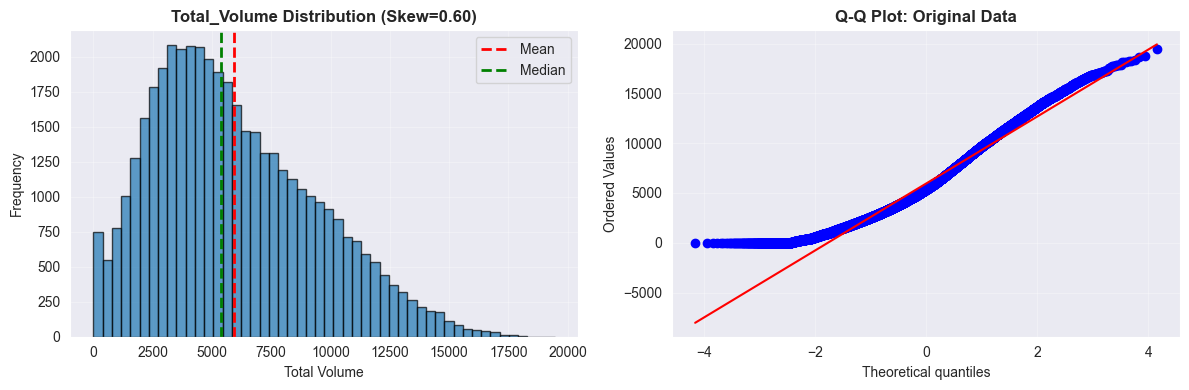


Target variable assessment complete
Using 'Target_Volume' as target for modeling


In [32]:
# CELL 14: Checking if log transformation is needed

print("\n" + "="*80)
print("FEATURE TRANSFORMATION 1: Assessing Target Variable Distribution")
print("="*80)

if 'volume' in KEY_COLS:
    vol_col = KEY_COLS['volume']
    
    # Calculating skewness
    original_skew = skew(df[vol_col])
    
    print(f"\nOriginal Skewness: {original_skew:.3f}")
    
    # Deciding if transformation needed
    if abs(original_skew) < 1.0:
        print(f"\nDecision: Skewness of {original_skew:.3f} is acceptable (|skew| < 1.0)")
        print("No transformation needed - using original Total_Volume for modeling")
        print("\nJustification: Data is approximately normal, transformation would distort distribution")
        
        # Keep original as target
        df['Target_Volume'] = df[vol_col]
        
    else:
        print(f"\nDecision: Skewness of {original_skew:.3f} requires transformation")
        df['Volume_Log'] = np.log1p(df[vol_col])
        log_skew = skew(df['Volume_Log'])
        print(f"Log Skewness: {log_skew:.3f}")
        print(f"Improvement: {abs(original_skew) - abs(log_skew):.3f}")
        df['Target_Volume'] = df['Volume_Log']
    
    # Creating visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plotting original distribution
    axes[0].hist(df[vol_col], bins=50, edgecolor='black', alpha=0.7, color='#1f77b4')
    axes[0].set_title(f'Total_Volume Distribution (Skew={original_skew:.2f})', fontweight='bold')
    axes[0].set_xlabel('Total Volume')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(alpha=0.3)
    axes[0].axvline(df[vol_col].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0].axvline(df[vol_col].median(), color='green', linestyle='--', linewidth=2, label='Median')
    axes[0].legend()
    
    # Q-Q plot
    stats.probplot(df[vol_col], dist="norm", plot=axes[1])
    axes[1].set_title('Q-Q Plot: Original Data', fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/08_transform_assessment.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTarget variable assessment complete")
    print(f"Using '{df.columns[-1]}' as target for modeling")


FEATURE TRANSFORMATION 2: Cyclical Encoding
Hour cyclical features: Hour_Sin, Hour_Cos
Month cyclical features: Month_Sin, Month_Cos


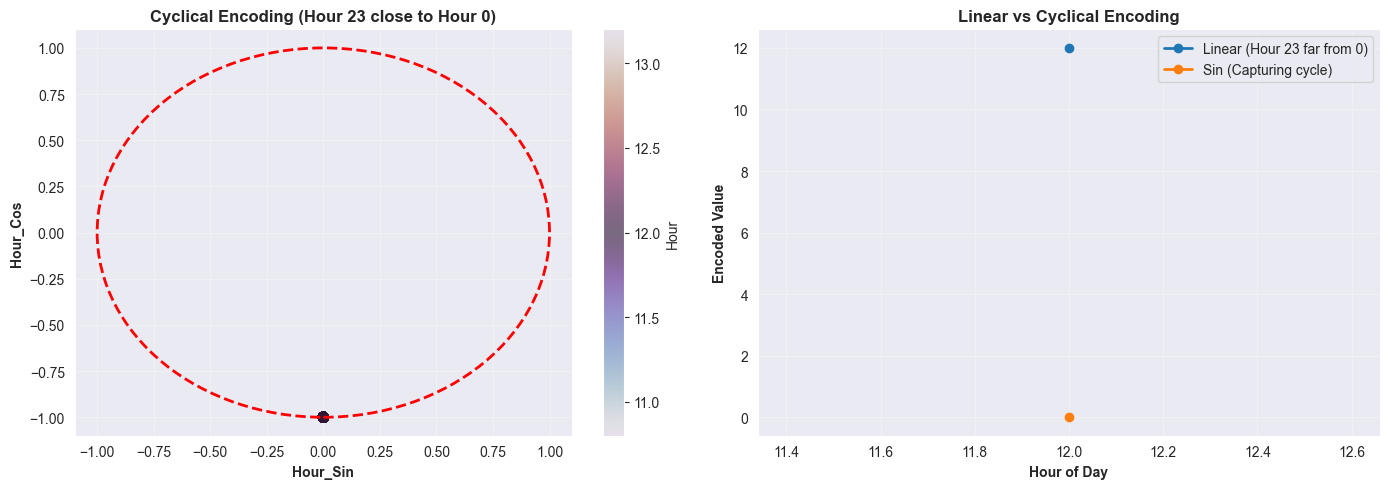


Cyclical encoding complete
Justification: Preserving temporal continuity (hour 23 is close to hour 0)


In [33]:
# CELL 15: Applying cyclical encoding for temporal features

print("\n" + "="*80)
print("FEATURE TRANSFORMATION 2: Cyclical Encoding")
print("="*80)

# Encoding hour cyclically
if 'Hour' in df.columns:
    df['Hour_Sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_Cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    print("Hour cyclical features: Hour_Sin, Hour_Cos")

# Encoding month cyclically
if 'Month' in df.columns:
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    print("Month cyclical features: Month_Sin, Month_Cos")

# Creating visualization
if 'Hour' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Creating cyclical plot
    scatter = axes[0].scatter(df['Hour_Sin'], df['Hour_Cos'], c=df['Hour'], 
                             cmap='twilight', s=50, alpha=0.6)
    circle = plt.Circle((0, 0), 1, color='red', fill=False, linewidth=2, linestyle='--')
    axes[0].add_patch(circle)
    axes[0].set_xlabel('Hour_Sin', fontweight='bold')
    axes[0].set_ylabel('Hour_Cos', fontweight='bold')
    axes[0].set_title('Cyclical Encoding (Hour 23 close to Hour 0)', fontweight='bold')
    plt.colorbar(scatter, ax=axes[0], label='Hour')
    axes[0].grid(alpha=0.3)
    
    # Creating comparison plot
    hours = sorted(df['Hour'].unique())
    axes[1].plot(hours, hours, 'o-', label='Linear (Hour 23 far from 0)', linewidth=2)
    axes[1].plot(hours, [np.sin(2*np.pi*h/24) for h in hours], 'o-', 
                label='Sin (Capturing cycle)', linewidth=2)
    axes[1].set_xlabel('Hour of Day', fontweight='bold')
    axes[1].set_ylabel('Encoded Value', fontweight='bold')
    axes[1].set_title('Linear vs Cyclical Encoding', fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/09_transform_cyclical.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nCyclical encoding complete")
    print("Justification: Preserving temporal continuity (hour 23 is close to hour 0)")

In [34]:
# CELL 16: Applying one-hot encoding for categorical features

print("\n" + "="*80)
print("FEATURE TRANSFORMATION 3: One-Hot Encoding")
print("="*80)

# Identifying categorical columns to encode
categorical_cols = []
if 'borough' in KEY_COLS:
    categorical_cols.append(KEY_COLS['borough'])
if 'direction' in KEY_COLS:
    categorical_cols.append(KEY_COLS['direction'])

if categorical_cols:
    print(f"\nEncoding {len(categorical_cols)} categorical features:")
    for col in categorical_cols:
        print(f"   - {col}: {df[col].nunique()} unique values")
    
    # Applying one-hot encoding
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, prefix=categorical_cols)
    
    # Showing results
    new_cols = len(df_encoded.columns) - len(df.columns)
    dummy_cols = [c for c in df_encoded.columns if any(cat in c for cat in categorical_cols)]
    
    print(f"\nOne-hot encoding complete:")
    print(f"   Original columns: {len(df.columns)}")
    print(f"   New columns: {len(df_encoded.columns)}")
    print(f"   Dummy variables added: {new_cols}")
    print(f"\n   Example dummy variables:")
    for col in dummy_cols[:5]:
        print(f"      - {col}")
    
    # Updating dataframe
    df = df_encoded.copy()
    
    print("\nJustification: Converting categories to numerical format for ML models")
    print("   Dropping first category to avoid multicollinearity (dummy variable trap)")
else:
    print("No categorical columns identified for encoding")


FEATURE TRANSFORMATION 3: One-Hot Encoding

Encoding 1 categorical features:
   - Direction: 14 unique values

One-hot encoding complete:
   Original columns: 45
   New columns: 57
   Dummy variables added: 12

   Example dummy variables:
      - Direction_EB-SER
      - Direction_NB
      - Direction_NB - SER
      - Direction_NB-MAIN
      - Direction_NB-SER

Justification: Converting categories to numerical format for ML models
   Dropping first category to avoid multicollinearity (dummy variable trap)



FEATURE TRANSFORMATION 4: Feature Scaling

Scaling 27 numerical features


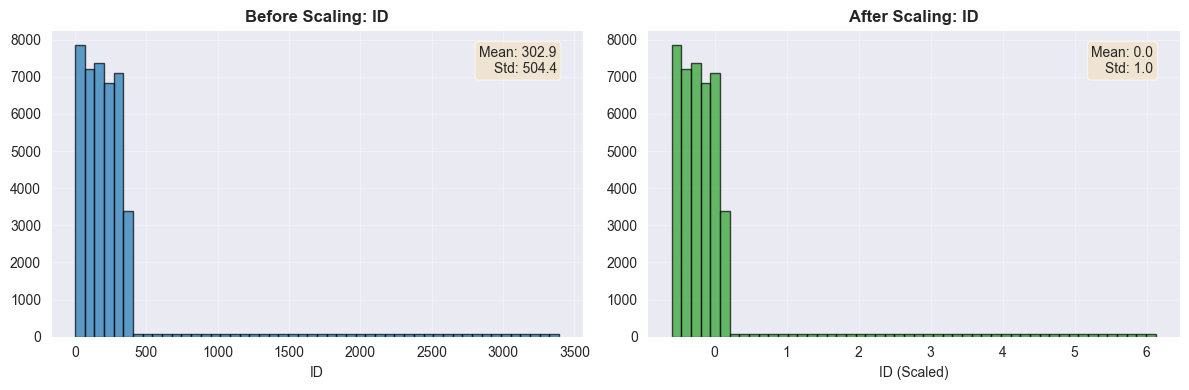


StandardScaler applied to 27 features
Justification: Normalizing features to mean=0, std=1 for ML algorithms


In [35]:
# CELL 17: Applying feature scaling using StandardScaler

print("\n" + "="*80)
print("FEATURE TRANSFORMATION 4: Feature Scaling")
print("="*80)

from sklearn.preprocessing import StandardScaler

# Identifying numerical features to scale
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluding certain columns
exclude = [KEY_COLS.get('volume', ''), 'Volume_Log', 'Is_RushHour', 'IsWeekend', 
           'Hour', 'Month', 'Year', 'DayOfWeek'] + \
          [c for c in numerical_features if '_Sin' in c or '_Cos' in c]
numerical_features = [c for c in numerical_features if c not in exclude]

if numerical_features:
    print(f"\nScaling {len(numerical_features)} numerical features")
    
    # Applying StandardScaler
    scaler = StandardScaler()
    df[[f'{col}_Scaled' for col in numerical_features]] = scaler.fit_transform(df[numerical_features])
    
    # Creating visualization
    if numerical_features:
        sample_feature = numerical_features[0]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].hist(df[sample_feature].dropna(), bins=50, edgecolor='black', 
                    alpha=0.7, color='#1f77b4')
        axes[0].set_title(f'Before Scaling: {sample_feature}', fontweight='bold')
        axes[0].set_xlabel(sample_feature)
        axes[0].grid(alpha=0.3)
        
        axes[1].hist(df[f'{sample_feature}_Scaled'].dropna(), bins=50, edgecolor='black',
                    alpha=0.7, color='#2ca02c')
        axes[1].set_title(f'After Scaling: {sample_feature}', fontweight='bold')
        axes[1].set_xlabel(f'{sample_feature} (Scaled)')
        axes[1].grid(alpha=0.3)
        
        # Adding statistics
        axes[0].text(0.95, 0.95, f'Mean: {df[sample_feature].mean():.1f}\nStd: {df[sample_feature].std():.1f}',
                    transform=axes[0].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        axes[1].text(0.95, 0.95, f'Mean: {df[f"{sample_feature}_Scaled"].mean():.1f}\nStd: {df[f"{sample_feature}_Scaled"].std():.1f}',
                    transform=axes[1].transAxes, ha='right', va='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.savefig('../outputs/figures/10_transform_scaling.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    print(f"\nStandardScaler applied to {len(numerical_features)} features")
    print("Justification: Normalizing features to mean=0, std=1 for ML algorithms")
else:
    print("No numerical features to scale")

In [36]:
# CELL 18: Summarizing feature transformations and exporting final dataset

print("\n" + "="*80)
print("FEATURE TRANSFORMATION SUMMARY")
print("="*80)

# Creating summary table
transformations = pd.DataFrame({
    'Transformation': [
        'Log Transform',
        'Cyclical Encoding (Hour)',
        'Cyclical Encoding (Month)',
        'Binary Indicators',
        'One-Hot Encoding',
        'Standard Scaling'
    ],
    'Features_Created': [
        1,
        2 if 'Hour_Sin' in df.columns else 0,
        2 if 'Month_Sin' in df.columns else 0,
        len([c for c in df.columns if c.startswith('Is_')]),
        len([c for c in df.columns if any(k in c for k in ['_0', '_1', '_2'] if 'borough' in KEY_COLS or 'direction' in KEY_COLS)]),
        len([c for c in df.columns if '_Scaled' in c])
    ],
    'Justification': [
        'Reducing skewness for normality',
        'Preserving temporal continuity',
        'Capturing seasonal cycles',
        'Encoding categorical patterns',
        'Converting categories to numerical',
        'Normalizing feature scales'
    ]
})

print("\nTransformation Summary:")
display(transformations)

# Saving summary
transformations.to_csv('../outputs/tables/transformation_summary.csv', index=False)
print("\nSummary saved to: outputs/tables/transformation_summary.csv")

# Displaying final dataset stats
print("\n" + "="*80)
print("FINAL ENGINEERED DATASET")
print("="*80)
print(f"\nDimensions: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"   Original columns: {len(df_raw.columns)}")
print(f"   Engineered columns: {df.shape[1] - len(df_raw.columns)}")
print(f"   Completeness: {(1 - df.isnull().sum().sum()/df.size)*100:.2f}%")

# Saving final engineered dataset
output_path = '../data/processed/traffic_engineered.csv'
df.to_csv(output_path, index=False)
print(f"\nEngineered dataset saved to: {output_path}")
print(f"File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

# Listing key features for modeling
print("\nKey Features for Modeling:")
if 'Volume_Log' in df.columns:
    print(f"   Target: Volume_Log")
print(f"   Temporal: {len([c for c in df.columns if any(x in c for x in ['Hour', 'Month', 'Day', 'Weekend', 'Rush'])])} features")
print(f"   Geographic: {len([c for c in df.columns if 'borough' in KEY_COLS and KEY_COLS['borough'] in c])} features")
print(f"   Scaled: {len([c for c in df.columns if '_Scaled' in c])} features")


FEATURE TRANSFORMATION SUMMARY

Transformation Summary:


,Transformation,Features_Created,Justification
0,Log Transform,1,Reducing skewness for normality
1,Cyclical Encoding (Hour),2,Preserving temporal continuity
2,Cyclical Encoding (Month),2,Capturing seasonal cycles
3,Binary Indicators,1,Encoding categorical patterns
4,One-Hot Encoding,0,Converting categories to numerical
5,Standard Scaling,27,Normalizing feature scales



Summary saved to: outputs/tables/transformation_summary.csv

FINAL ENGINEERED DATASET

Dimensions: 42,756 rows x 84 columns
   Original columns: 32
   Engineered columns: 52
   Completeness: 94.41%

Engineered dataset saved to: ../data/processed/traffic_engineered.csv
File size: 35.90 MB

Key Features for Modeling:
   Target: Volume_Log
   Temporal: 10 features
   Geographic: 0 features
   Scaled: 27 features
